In [1]:
using PyCall
using PyPlot

In [2]:
function read_lammps_output_file(lammps_output_filename::String)
    # read in lines of QE output file
    lammps_file = open(lammps_output_filename)
    lines = readlines(lammps_file)
    close(lammps_file)
    return lines
end

read_lammps_output_file (generic function with 1 method)

In [3]:
function get_thermo_data(lines::Array{String, 1})
    
    data_start = 0
    data_stop  = 0
    for (i, line) in enumerate(lines)
        if occursin("Step", line) && occursin("c_msd", line)
            data_start = i
        elseif occursin("Loop", line) && (data_start != 0)
            data_stop  = i
        end
    end
    
    println("data_start = ", data_start)
    println("data_stop  = ", data_stop)
    
    num_data = data_stop - data_start - 1
    data = Dict{String, Array{Any, 1}}("Step"       => zeros(Int64, num_data),
                                       "v_eqtemp"   => zeros(Int64, num_data),
                                       "c_msd"      => zeros(Float64, num_data),
                                       "v_fitslope" => zeros(Float64, num_data)
                                      )
    
    for (i, line) in enumerate(lines[data_start+1:data_stop-1])
        data["Step"][i]       = parse(Int64, split(line)[1])
        data["v_eqtemp"][i]   = parse(Int64, split(line)[2])
        data["c_msd"][i]      = parse(Float64, split(line)[3])
        data["v_fitslope"][i] = parse(Float64, split(line)[4])
    end
    return data
end

get_thermo_data (generic function with 1 method)

In [4]:
# filename = joinpath(pwd(), "log.NiPyC2_experiment_with_Xe")

# lines = read_lammps_output_file(filename)

# sim_data = get_thermo_data(lines)

# length(sim_data["c_msd"])

In [5]:
# which xtals are we looking at
xtals = ["NiPyC2_experiment"] # ["NiPyC2_experiment", "Pn_Ni-PyC-NH2"]
# which adsorbated are we condidering
adsorbates = ["Xe"] # ["Kr", "Xe"] # "Ar", "Kr", "Xe"
# initialize Dict to store data
# Tuple is (xtal, gas)
sim_data = Dict{Tuple{String, String}, Dict{String, Array{Any, 1}}}()

# loop over xtals
for xtal in xtals
    # loop over adsorbates
    for gas in adsorbates
        # define filemane
        filename = joinpath(pwd(), "log." * xtal * "_with_" * gas)
        println(filename)
        # read file
        lines = read_lammps_output_file(filename)
        # get desired data and store in a Dict
        sim_data[(xtal, gas)] = get_thermo_data(lines)
        
#         ###
#         # Simulation output is in Å²/fs and we want to convert that to cm²/s
#         # 1 Å  = 10⁻⁸cm
#         # 1 fs = 10⁻¹⁵ s
#         # 1 Å²/fs * (10¹⁵ fs/s)*(10⁻¹⁶ cm²/Å²) = 0.1 cm²/s
#         # So, 1 cm²/s = 10 Å²/fs
#         ###
#         conversion_factor = 10 
#         # apply conversion 
#         sim_data[(xtal, gas)]["diffusion coeff. [cm²/s]"] = sim_data[(xtal, gas)]["v_fitslope"] * conversion_factor
    end
end

/home/ng/NiPyC_analogues/lammps_diffusion_calcs/log.NiPyC2_experiment_with_Xe
data_start = 194
data_stop  = 100196


In [6]:
# for xtal in xtals
#     # loop over adsorbates
#     for gas in adsorbates
#         println(xtal, " with ", gas, ":\t", 
#             last(sim_data[xtal, gas]["diffusion coeff. [cm²/s]"]))
#     end
# end

### Diffusive Selectivity

In [7]:
# # Henry Coefficients needed for calculation
# henry_coeffs = Dict(("NiPyC2_experiment", "Xe") => 53.78,
#                     ("NiPyC2_experiment", "Kr") => 3.14,
#                     ("NiPyC2_experiment", "Ar") => 0.45,
#                     ("Pn_Ni-PyC-NH2", "Xe") => 98.25,
#                     ("Pn_Ni-PyC-NH2", "Kr") => 4.85,
#                     ("Pn_Ni-PyC-NH2", "Ar") => 0.55
#                    )

In [8]:
# println("Ideal Membrane Selectivity - ")
# for xtal in xtals
#     println("\t", xtal, ":")
#     for (i, gas1) in enumerate(adsorbates)
#         for (j, gas2) in enumerate(adsorbates)
#             if i <= j
#                 continue
#             else
#                 d1 = sim_data[xtal, gas1]["diffusion coeff. [cm²/s]"][end]
#                 h1 = henry_coeffs[(xtal, gas1)]
                
#                 d2 = sim_data[xtal, gas2]["diffusion coeff. [cm²/s]"][end]
#                 h2 = henry_coeffs[(xtal, gas2)]
                
#                 mem_selectivity = (h1 * d1) / (h2 * d2)
                
#                 println("\t\t", gas1, "/", gas2, " = ", mem_selectivity)
#             end
#         end
#     end
# end

## PLOTS

TODO:
Block everaging for msd to get less noisy results and slope.

### Xe

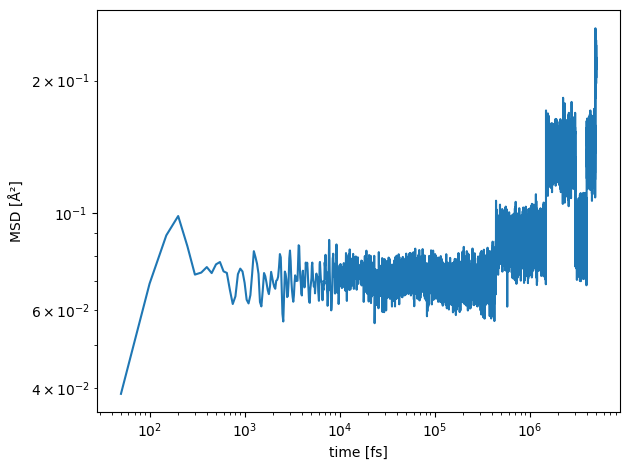

In [9]:
figure()

msd  = sim_data[("NiPyC2_experiment", "Xe")]["c_msd"]
time = sim_data[("NiPyC2_experiment", "Xe")]["Step"] 

loglog(time[2:end], msd[2:end])

xlabel("time [fs]")
ylabel("MSD [Å²]")

tight_layout()

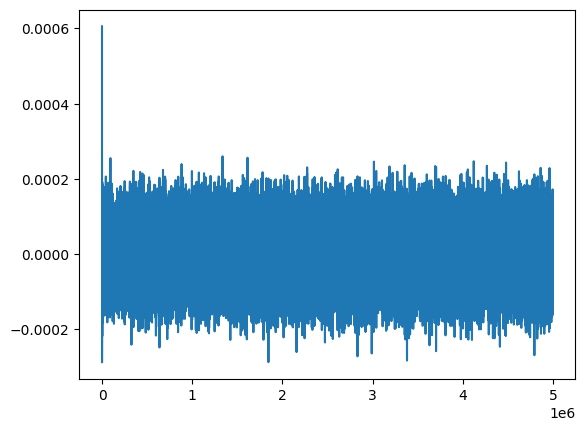

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b0b6efb80>

In [10]:
figure()

slope = [(msd[i+1] - msd[i])/(time[i+1] - time[i]) for i in 2:length(msd)-1]

plot(time[2:end-1], slope)

In [11]:
# figure()

# msd  = sim_data[("Pn_Ni-PyC-NH2", "Xe")]["c_msd"]
# time = sim_data[("Pn_Ni-PyC-NH2", "Xe")]["Step"] / 1000

# loglog(time[2:end], msd[2:end], color="r")

# xlabel("time [ps]")
# ylabel("MSD [Å²]")

# tight_layout()

In [12]:
# figure()

# slope = [(msd[i+1] - msd[i])/(time[i+1] - time[i]) for i in 2:length(msd)-1]

# plot(time[2:end-1], slope)

### Kr

In [13]:
figure()

msd  = sim_data[("NiPyC2_experiment", "Kr")]["c_msd"]
time = sim_data[("NiPyC2_experiment", "Kr")]["Step"] / 1000

loglog(time[2:end], msd[2:end])

xlabel("time [ps]")
ylabel("MSD [Å²]")

tight_layout()

LoadError: KeyError: key ("NiPyC2_experiment", "Kr") not found

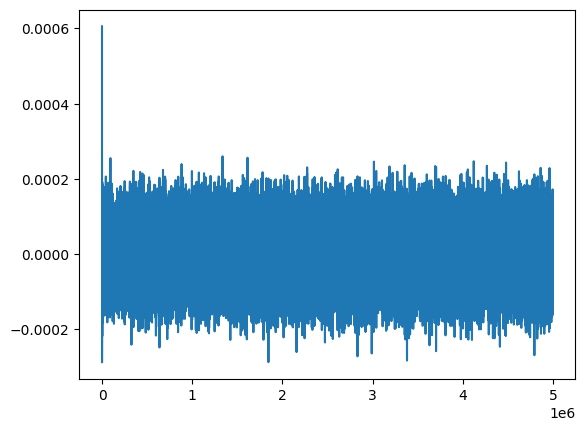

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b0b550cd0>

In [14]:
figure()

slope = [(msd[i+1] - msd[i])/(time[i+1] - time[i]) for i in 2:length(msd)-1]

plot(time[2:end-1], slope)

In [15]:
figure()

msd  = sim_data[("Pn_Ni-PyC-NH2", "Kr")]["c_msd"]
time = sim_data[("Pn_Ni-PyC-NH2", "Kr")]["Step"] / 1000

loglog(time[2:end], msd[2:end], color="r")

xlabel("time [ps]")
ylabel("MSD [Å²]")

tight_layout()

LoadError: KeyError: key ("Pn_Ni-PyC-NH2", "Kr") not found

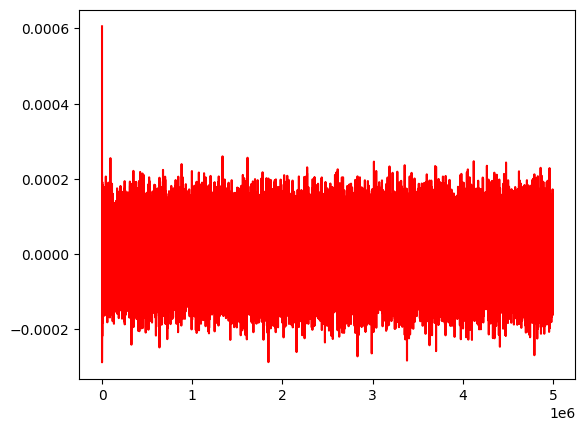

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b0b5f8a90>

In [16]:
figure()

slope = [(msd[i+1] - msd[i])/(time[i+1] - time[i]) for i in 2:length(msd)-1]

plot(time[2:end-1], slope, color="r")